In [1]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, BertModel
import torch

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
file_name='train-balanced-sarcasm.csv'

In [7]:
train_df = pd.read_csv(file_name)

In [8]:
train_df.dropna(axis=0,subset=['comment'],inplace=True)

In [9]:
train_df[train_df.isnull().any(axis=1)]['comment']

Series([], Name: comment, dtype: object)

In [10]:
train_df = train_df.iloc[:50000]

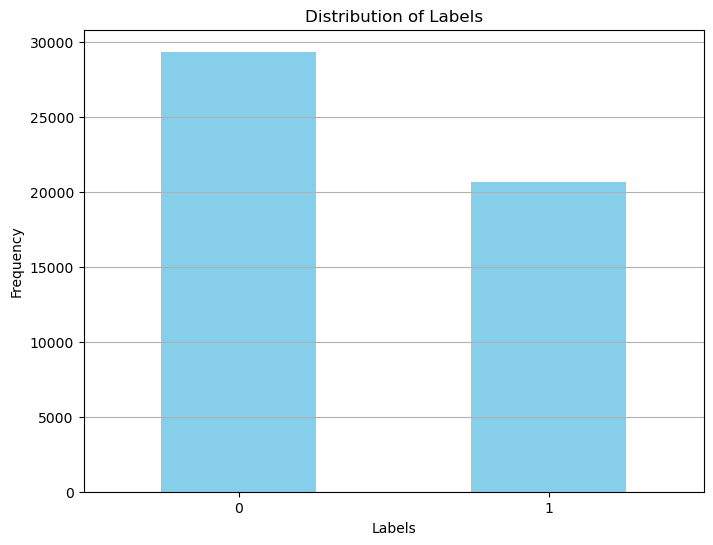

In [11]:
plt.figure(figsize=(8, 6))
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'

        

In [13]:
x_preprocessed = [preprocess(row) for row in train_df['comment']]

In [14]:
y=train_df['label']

In [15]:
train_x, eval_x, train_y, eval_y=train_test_split(x_preprocessed,y,test_size=0.2,train_size=0.8,stratify=y)

In [16]:
len(eval_x)

10000

In [17]:
train_data = {'text': train_x, 'labels': train_y}
train_dataset = Dataset.from_dict(train_data)

eval_data = {'text': eval_x, 'labels': eval_y}
eval_dataset = Dataset.from_dict(eval_data)

In [18]:

# Define the model name
model_name = "distilbert-base-uncased"

# Load the tokenizer and model using Auto classes
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Tokenize the train and eval datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) 

Using device: cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [21]:
# Define training arguments with logging and evaluation strategy
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # set to 'steps'
    logging_dir="./logs",  # Directory to store logs
    logging_steps=1000,  # Log every 100 steps
    save_strategy="epoch",  # Save checkpoint every 'steps'
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    report_to=None,  # This will allow me to visualize the metrics with TensorBoard

)

# Initialize the Trainer with the training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)


C:\Users\acer\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\acer\AppData\Local\Temp\ipykernel_5988\35351600.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.608100,0.627311
2,0.556000,0.693830
3,0.545600,1.027796
4,0.446000,1.593459
5,0.282300,1.955247
6,0.222000,2.208414


TrainOutput(global_step=60000, training_loss=0.4409047587076823, metrics={'train_runtime': 8749.0971, 'train_samples_per_second': 27.431, 'train_steps_per_second': 6.858, 'total_flos': 7503631320392400.0, 'train_loss': 0.4409047587076823, 'epoch': 6.0})

In [23]:

# Get predictions and true labels from the eval dataset
predictions = trainer.predict(eval_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

In [24]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp)

Accuracy: 0.6694
Precision: 0.6056733963710708
Recall: 0.5734333413984999
F1 Score: 0.5891126025354213
Confusion Matrix:
[[4324 1543]
 [1763 2370]]
4324 1543 1763 2370


In [25]:
# Saving the model
trainer.save_model("./saved_model")

# Saving the tokenizer
tokenizer.save_pretrained("./saved_model")



('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')